## DZ_7

### Данные:

Датасет разделен на две части: тренировочную (banking_training.csv) и тестовую (banking_test.csv). Используя banking_training.csv происходит тренировка алгоритма, предсказание осуществляется на banking_test.csv.

Описание фичей данных находится в файле banking_desc.csv


### Задача:

Бинарная вероятностная классификация.

Ваша задача спрогнозировать возниконение трудностей у кредитора в течение двух лет (переменная SeriousDlqin2yrs, принимающая значения [0,1]). Также необходимо спрогнозировать вероятность для данной переменной SeriousDlqin2yrs.

Алгоритм для выполнения задачи можно выбирать любой.

### Ход работы:

1. Провести первичный анализ данных: описательные статистики, распределения, наличия пропущенных значений.

2. Осуществить препроцессинг и подготовку данных: выбрать стратегию работы с пропущенными значениями, при необходимости осуществить генерацию дополнительных фичей (пояснить логику). 

3. Провести корреляционный анализ и проверить выбор дополнительных фичей в сете.

4. Отобрать фичи для построения модели используя подход Wrapper methods или любой из методов Univariate Feature Selection (к примеру SelectKBest или SelectPercentile).

5. Протестировать на тренировочном дата сете различные наборы фичей и их работу с выбранными алгоритмами для осуществления предсказания.

6. Выбрать лучший набор фичей и лучший алгоритм для осуществленния как предсказания классов так и вероятности. Провести сравнение на тестовой выборке используя следующие метрики для оценки качества алгоритма: 

    -Классификация: Accuracy Score, f1-Score, Precision, Recall
    
    -Вероятность: log_loss Score    
    


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

In [2]:
df = pd.read_csv('banking_train.csv')

In [3]:
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,57836,0,0.114987,62,0,1841.000000,NaN,5,0,1,0,2.0
1,132895,0,0.008705,73,0,0.498553,3800.0,6,0,1,0,0.0
2,27981,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0
3,37852,0,1.000000,60,0,118.000000,NaN,5,0,0,0,0.0
4,103813,0,0.230493,60,0,1.017328,3000.0,10,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
119995,18048,0,0.004136,41,0,0.472323,7695.0,9,0,2,0,0.0
119996,3895,0,0.000000,49,0,0.322344,8583.0,18,0,1,0,1.0
119997,109980,0,1.000000,80,0,35.000000,NaN,0,0,0,0,0.0
119998,74354,0,0.925187,63,0,0.389974,1535.0,2,1,0,0,0.0


In [4]:
#удаляем первый столбец
del df['Unnamed: 0']

In [5]:
#анализ датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      120000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  120000 non-null  float64
 2   age                                   120000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  120000 non-null  int64  
 4   DebtRatio                             120000 non-null  float64
 5   MonthlyIncome                         96325 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       120000 non-null  int64  
 7   NumberOfTimes90DaysLate               120000 non-null  int64  
 8   NumberRealEstateLoansOrLines          120000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  120000 non-null  int64  
 10  NumberOfDependents                    116872 non-null  float64
dtype

In [6]:
#заполнение пустых значений иждивенцев медианным значением
numberOfDependentsMedian = df['NumberOfDependents'].median()
df['NumberOfDependents'].fillna(value = numberOfDependentsMedian, inplace = True)

In [7]:
#заполнение пустых значений зарплат 1(причина:высокий DebtRatio для всех пустых значений)
df['MonthlyIncome'].fillna(value = 1, inplace = True)

In [8]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.114987,62,0,1841.000000,1.0,5,0,1,0,2.0
1,0,0.008705,73,0,0.498553,3800.0,6,0,1,0,0.0
2,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0
3,0,1.000000,60,0,118.000000,1.0,5,0,0,0,0.0
4,0,0.230493,60,0,1.017328,3000.0,10,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
119995,0,0.004136,41,0,0.472323,7695.0,9,0,2,0,0.0
119996,0,0.000000,49,0,0.322344,8583.0,18,0,1,0,1.0
119997,0,1.000000,80,0,35.000000,1.0,0,0,0,0,0.0
119998,0,0.925187,63,0,0.389974,1535.0,2,1,0,0,0.0


In [9]:
#просмотр пустых значений
df.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [10]:
#общий долг по кредитам
df['DebtPayments'] = df['MonthlyIncome'] * df['DebtRatio']

In [11]:
#удаление столбцов с очевидным выбросом (возраст кредитора меньше 18)
df = df[~df['age'] < 18]

In [12]:
#доля дохода с учетом иждивенцев
df['IncomePerPerson'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)

Text(0.5, 1.05, 'Correlation Matrix')

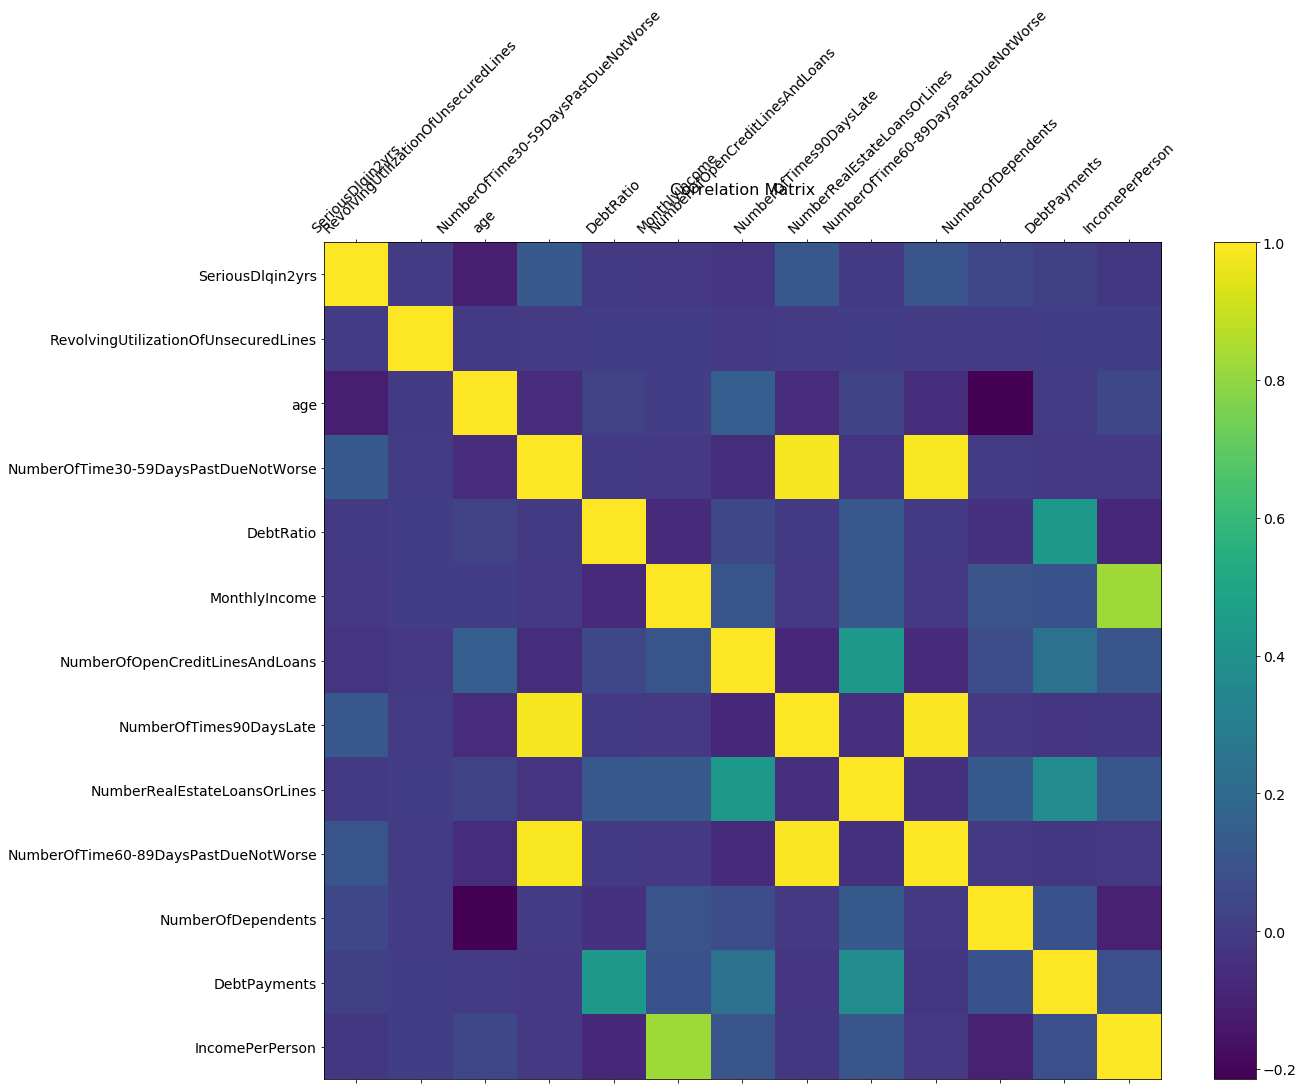

In [13]:
#Матрица корреляции
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum = f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [14]:
#feature selection показал, что столбец с числом иждивинцев избыточен
y = df['SeriousDlqin2yrs']
X = df.drop(['SeriousDlqin2yrs', 'NumberOfDependents'], axis=1)

In [15]:
Xtrain, Xtest,ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)

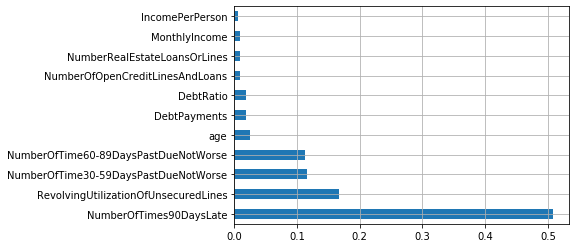

In [17]:
gradientBoostingClassifier = GradientBoostingClassifier(random_state = 42, n_estimators = 150)
gradientBoostingClassifier.fit(Xtrain, ytrain)
imp = pd.Series(gradientBoostingClassifier.feature_importances_, index = X.columns).sort_values(ascending=False).iloc[:20].plot(kind='barh')
plt.grid();

In [18]:
report = classification_report(ytest,gradientBoostingClassifier.predict(Xtest), digits = 5)
print(report)

              precision    recall  f1-score   support

           0    0.95510   0.95780   0.95645     22344
           1    0.40804   0.39251   0.40012      1656

    accuracy                        0.91879     24000
   macro avg    0.68157   0.67515   0.67829     24000
weighted avg    0.91736   0.91879   0.91806     24000



In [22]:
def seeResultWithTrainAndTest(dfTrain, dfTest):
    
    dfTrain = pd.read_csv(dfTrain)
    dfTest = pd.read_csv(dfTest)
    
    del dfTrain['Unnamed: 0']
    del dfTest['Unnamed: 0']
    
    numberOfDependentsMedianTrain = dfTrain['NumberOfDependents'].median()
    numberOfDependentsMedianTest = dfTest['NumberOfDependents'].median()
    dfTrain['NumberOfDependents'].fillna(value = numberOfDependentsMedianTrain, inplace = True)
    dfTest['NumberOfDependents'].fillna(value = numberOfDependentsMedianTest, inplace = True)
    
    dfTrain['MonthlyIncome'].fillna(value = 1, inplace = True)
    dfTest['MonthlyIncome'].fillna(value = 1, inplace = True)
    
    dfTrain['DebtPayments'] = dfTrain['MonthlyIncome'] * dfTrain['DebtRatio']
    dfTest['DebtPayments'] = dfTest['MonthlyIncome'] * dfTest['DebtRatio']
    
    dfTrain['IncomePerPerson'] = dfTrain['MonthlyIncome'] / (dfTrain['NumberOfDependents'] + 1)
    dfTest['IncomePerPerson'] = dfTest['MonthlyIncome'] / (dfTest['NumberOfDependents'] + 1)
    
    dfTrain = dfTrain[~dfTrain['age'] < 18]
    dfTest = dfTest[~dfTest['age'] < 18]
    
    y_train = dfTrain['SeriousDlqin2yrs']
    y_test = dfTest['SeriousDlqin2yrs']
    X_train = dfTrain.drop(['SeriousDlqin2yrs', 'NumberOfDependents'], axis=1)
    X_test = dfTest.drop(['SeriousDlqin2yrs', 'NumberOfDependents'], axis=1)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    gradientBoostingClassifier = GradientBoostingClassifier(random_state = 42, n_estimators = 150)
    gradientBoostingClassifier.fit(X_train, y_train)
    
    report = classification_report(y_test,gradientBoostingClassifier.predict(X_test), digits = 5)
    print(report)

In [23]:
def seeResultWithTest(dfTest):
    
    dfTest = pd.read_csv(dfTest)

    del dfTest['Unnamed: 0']
    
    numberOfDependentsMedianTest = dfTest['NumberOfDependents'].median()
    dfTest['NumberOfDependents'].fillna(value = numberOfDependentsMedianTest, inplace = True)
    dfTest['MonthlyIncome'].fillna(value = 1, inplace = True)
    
    dfTest['DebtPayments'] = dfTest['MonthlyIncome'] * dfTest['DebtRatio']
    dfTest['IncomePerPerson'] = dfTest['MonthlyIncome'] / (dfTest['NumberOfDependents'] + 1)
    
    dfTest = dfTest[~dfTest['age'] < 18]
    
    y = dfTest['SeriousDlqin2yrs']
    X = dfTest.drop(['SeriousDlqin2yrs', 'NumberOfDependents'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    gradientBoostingClassifier = GradientBoostingClassifier(random_state = 42, n_estimators = 150)
    gradientBoostingClassifier.fit(X_train, y_train)
    
    report = classification_report(y_test,gradientBoostingClassifier.predict(X_test), digits = 5)
    print(report)

In [ ]:
#раскомментировать закомментированные строки, чтобы увидеть ответ
filenameTrain = 'banking_train.csv'
filenameTest = 'banking_test.csv'
seeResultWithTrainAndTest(filenameTrain, filenameTest)

In [ ]:
seeResultWithTest(filenameTest)